# Experiments with dim reduction

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from sklearn import decomposition
import seaborn
from  matplotlib import pyplot
from matplotlib.pyplot import figure
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


df = pd.read_excel('Cities.xls', index_col=0, skipinitialspace=True) # Read with excel index. 
# Skip all white-spaces.

In [5]:
corrMatrix = df.corr()

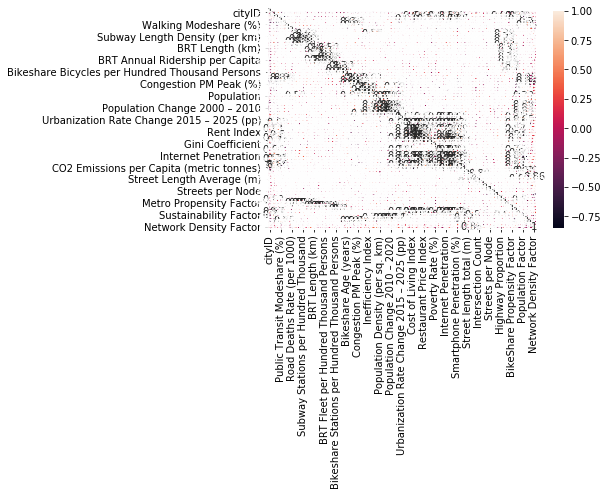

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [7]:
df = df.set_index('cityID') # Remove the indices and use cityID as index.

# Drop unnecessary columns (that explicitly imply each other)
# cityID implies City
# clusterID implies Typology
# Pollution Index is restricted to be used in prediction.
col2drop = ['City', 'Typology', 'Pollution Index ']
# col2drop = ['City', 'Typology']



df.drop(col2drop, inplace=True, axis=1) # Typology <=> clusterID, City <=> cityID, 
# df.drop("Pollution Index", axis=1)
# df.info()
# df["Pollution Index"]

In [8]:
df = df.replace(r'^\s*$', np.NaN, regex=True)
print("Initial dataframe shape [rows, columns]:", df.shape)
n_NaN = df.isna().sum().sum()
print(n_NaN) # As you can see the total number of NaNs in the database 3199, so we need to impute.

Initial dataframe shape [rows, columns]: (331, 74)
3040


In [9]:
df

clusterID                           Country  Car Modeshare (%)  \
cityID                                                                   
285             7                     United States            85.0000   
10              8                         Australia            80.0000   
186             1                             Niger                NaN   
328            12                           Vietnam             8.0000   
67             12                             China            21.7000   
297             7                     United States            88.6000   
90              9                            France            12.0000   
322             5                           Uruguay                NaN   
201             5                            Poland            27.0000   
209             2                            Russia                NaN   
120             3                             India            54.0000   
199             1                       Philippines                NaN   
29              1                       Ivory Coast                NaN   
301             7                     United States            86.8000   
32              1                          Cameroon                NaN   
113             3                             India            19.0000   
68             12                             China            42.0000   
258             7              United Arab Emirates            50.0000   
269             8                     United States            78.0000   
63             12                             China                NaN   
327            12                           Vietnam            11.0000   
256             6                           Ukraine                NaN   
185             1                         Nicaragua                NaN   
181             1                             Nepal                NaN   
14              3                        Bangladesh                NaN   
191             3                          Pakistan            48.0000   
264            10                    United Kingdom            68.0700   
5               1                            Angola                NaN   
20              2                           Bolivia                NaN   
93             10                            France            57.0000   
133             2                              Iraq                NaN   
177             1                           Morocco             9.0000   
47             11                             China            20.6000   
101            10                           Germany            43.0000   
2               1                           Algeria            12.8000   
117             3                             India            25.0000   
153             1                             Kenya             0.0000   
235            10                             Spain            30.0000   
233             7                       South Korea                NaN   
162             2                          Malaysia                NaN   
273             8                     United States            86.8000   
211             2                            Russia                NaN   
33              8                            Canada            64.5000   
89             10                           Finland            21.0000   
252             6                            Turkey                NaN   
268             8                     United States            84.7000   
135            10                           Ireland            64.0000   
173             4                            Mexico                NaN   
223             1                           Somalia                NaN   
210             2                            Russia                NaN   
195             4                              Peru            12.0000   
308             7                     United States            90.5000   
126         

# Congestion Prediction

Next thing we would like to try is to predict congestion - either by percentage congestion variable or congestion factor. We would like to find out if there is some relationship between congestions and weather, for example if the cities in hot climate are more likely to be congested. The plan is following - We will use dataset from https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities which contains temperature observation of major cities. Choose one day to get one temperature measurement, pair it with the cities dataset and then apply Gaussian mixture model. The missing observations for temperature will be either imputed or find in another dataset.

In [36]:
#we will nedd the city column again
dfcity = pd.read_excel('Cities.xls', index_col=0, skipinitialspace=True) # Read with excel index. 

In [37]:
dftemp =pd.read_csv('city_temperature.csv', index_col=0, skipinitialspace=True) # Read with excel index. 

C:\Users\vilem\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
dftemp.head(15)

Country State     City  Month  Day  Year  AvgTemperature
Region                                                          
Africa  Algeria   NaN  Algiers      1    1  1995            64.2
Africa  Algeria   NaN  Algiers      1    2  1995            49.4
Africa  Algeria   NaN  Algiers      1    3  1995            48.8
Africa  Algeria   NaN  Algiers      1    4  1995            46.4
Africa  Algeria   NaN  Algiers      1    5  1995            47.9
Africa  Algeria   NaN  Algiers      1    6  1995            48.7
Africa  Algeria   NaN  Algiers      1    7  1995            48.9
Africa  Algeria   NaN  Algiers      1    8  1995            49.1
Africa  Algeria   NaN  Algiers      1    9  1995            49.0
Africa  Algeria   NaN  Algiers      1   10  1995            51.9
Africa  Algeria   NaN  Algiers      1   11  1995            51.7
Africa  Algeria   NaN  Algiers      1   12  1995            51.3
Africa  Algeria   NaN  Algiers      1   13  1995            47.0
Africa  Algeria   NaN  Algiers      1   14  1995            46.9
Africa  Algeria   NaN  Algiers      1   15  1995            47.5

In [39]:
#dropping unneccesary columns
col2drop = ['Country', 'State']

dftemp.drop(col2drop, inplace=True, axis=1) # Typology <=> clusterID, City <=> cityID, 

In [40]:
#Before merging with our dataset its neccessary to choose only one day
new_dftemp = dftemp.loc[(dftemp['Month'] == 11) & (dftemp['Day'] == 16) & (dftemp['Year'] == 2019)]

In [41]:
df_new=pd.merge(dfcity, new_dftemp, on='City', how='outer')

In [42]:
col2drop = ['Month', 'Day','Year']

df_new.drop(col2drop, inplace=True, axis=1) # Typology <=> clusterID, City <=> cityID,

In [43]:
df_new

City  cityID  clusterID                 Typology  \
0                 Baltimore(MD)   285.0        7.0              Auto Sprawl   
1                     Melbourne    10.0        8.0          Auto Innovative   
2                        Niamey   186.0        1.0       Congested Emerging   
3                         Hanoi   328.0       12.0       MetroBike Emerging   
4                        Urumqi    67.0       12.0       MetroBike Emerging   
5                 Milwaukee(WI)   297.0        7.0              Auto Sprawl   
6                         Paris    90.0        9.0  MassTransit Heavyweight   
7                    Montevideo   322.0        5.0          Hybrid Moderate   
8                        Krakow   201.0        5.0          Hybrid Moderate   
9                 Yekaterinburg   209.0        2.0        BusTransit Sprawl   
10                         Pune   120.0        3.0         Congested Boomer   
11                         Cebu   199.0        1.0       Congested Emerging   
12                      Abidjan    29.0        1.0       Congested Emerging   
13                   Austin(TX)   301.0        7.0              Auto Sprawl   
14                      Yaounde    32.0        1.0       Congested Emerging   
15                        Delhi   113.0        3.0         Congested Boomer   
16                        Hefei    68.0       12.0       MetroBike Emerging   
17                        Dubai   258.0        7.0              Auto Sprawl   
18                  Chicago(IL)   269.0        8.0          Auto Innovative   
19                       Dalian    63.0       12.0       MetroBike Emerging   
20             Ho Chi Minh City   327.0       12.0       MetroBike Emerging   
21                      Kharkiv   256.0        6.0             Hybrid Giant   
22                      Managua   185.0        1.0       Congested Emerging   
23                    Kathmandu   181.0        1.0       Congested Emerging   
24                   Chittagong    14.0        3.0         Congested Boomer   
25                      Karachi   191.0        3.0         Congested Boomer   
26                      Glasgow   264.0       10.0     MassTransit Moderate   
27                       Huambo     5.0        1.0       Congested Emerging   
28                   Santa Cruz    20.0        2.0        BusTransit Sprawl   
29                        Lille    93.0       10.0     MassTransit Moderate   
30                      Baghdad   133.0        2.0        BusTransit Sprawl   
31                        Rabat   177.0        1.0       Congested Emerging   
32                    Chongqing    47.0       11.0          MetroBike Giant   
33                 Cologne-Bonn   101.0       10.0     MassTransit Moderate   
34                      Algiers     2.0        1.0       Congested Emerging   
35                    Bangalore   117.0        3.0         Congested Boomer   
36                      Mombasa   153.0        1.0       Congested Emerging   
37                    Barcelona   235.0       10.0     MassTransit Moderate   
38                        Ulsan   233.0        7.0              Auto Sprawl   
39                  Johor Bahru   162.0        2.0        BusTransit Sprawl   
40                  Atlanta(GA)   273.0        8.0          Auto Innovative   
41                       Samara   211.0        2.0        BusTransit Sprawl   
42                      Toronto    33.0        8.0          Auto Innovative   
43                     Helsinki    89.0       10.0     MassTransit Moderate   
44                        Bursa   252.0        6.0             Hybrid Giant   
45              Los Angeles(CA)   268.0        8.0          Auto Innovative   
46                       Dublin   135.0       10.0     MassTransit Moderate   
47                     Acapulco   173.0        4.0         BusTransit Dense   
48                    Mogadishu   223.0        1.0       Congested Emerging   
49              Nizhny Novgorod   210.0        2.0        BusTransit Sprawl  

In [44]:
#dropping cities that did not find match
df_new = df_new[df_new['Country'].notna()]
df_new.sample(n=20, random_state=1)

City  cityID  clusterID                 Typology  \
59         Lubumbashi    76.0        1.0       Congested Emerging   
268             Kabul     1.0        1.0       Congested Emerging   
180  Phoenix-Mesa(AZ)   278.0        7.0              Auto Sprawl   
192          Salvador    24.0        1.0       Congested Emerging   
284            Odessa   257.0        1.0       Congested Emerging   
177             Dakar   218.0        1.0       Congested Emerging   
92              Milan   140.0       10.0     MassTransit Moderate   
187            Fuzhou    69.0       12.0       MetroBike Emerging   
89          Guangzhou    45.0       11.0          MetroBike Giant   
189         Hiroshima   149.0        6.0             Hybrid Giant   
213           Kunming    62.0       12.0       MetroBike Emerging   
4              Urumqi    67.0       12.0       MetroBike Emerging   
58          Chihuahua   174.0        2.0        BusTransit Sprawl   
167      Shijiazhuang    70.0       12.0       MetroBike Emerging   
206             Daegu   230.0        6.0             Hybrid Giant   
158          Taichung   244.0        5.0          Hybrid Moderate   
186       Memphis(TN)   302.0        7.0              Auto Sprawl   
174         Maracaibo   325.0        2.0        BusTransit Sprawl   
6               Paris    90.0        9.0  MassTransit Heavyweight   
120           Kampala   254.0        1.0       Congested Emerging   

                              Country  Car Modeshare (%)  \
59   Democratic Republic of the Congo                NaN   
268                       Afghanistan               17.7   
180                     United States               87.5   
192                            Brazil               22.9   
284                           Ukraine                NaN   
177                           Senegal               11.0   
92                              Italy               36.0   
187                             China                NaN   
89                              China               21.0   
189                             Japan               12.0   
213                             China               22.1   
4                               China               21.7   
58                             Mexico               63.4   
167                             China                5.0   
206                       South Korea                NaN   
158                            Taiwan               46.0   
186                     United States               93.0   
174                         Venezuela                NaN   
6                              France               12.0   
120                            Uganda                9.0   

     Public Transit Modeshare (%) Bicycle Modeshare (%)  \
59                            NaN                   NaN   
268                         49.60                     0   
180                          1.80                   0.7   
192                         44.23                   NaN   
284                           NaN                   NaN   
177                         76.00                   NaN   
92                          41.00                     6   
187                           NaN                    37   
89                          32.00                     9   
189                         51.00                    14   
213                         25.20                  55.3   
4                           54.70                   NaN   
58                          14.40                   NaN   
167                          7.16                 47.28   
206                           NaN                   NaN   
158                         34.00                     4   
186                          1.10                   0.1   
174                           NaN                   NaN   
6                           33.00                     3   
120                         82.00                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
59 

# Imputing transport modal shares and temperatature

In [45]:
df_new.loc[(df_new['Country'] == 'France')]

City  cityID  clusterID                 Typology Country  \
6        Paris    90.0        9.0  MassTransit Heavyweight  France   
29       Lille    93.0       10.0     MassTransit Moderate  France   
93    Bordeaux    96.0       10.0     MassTransit Moderate  France   
104       Lyon    92.0       10.0     MassTransit Moderate  France   
124   Toulouse    95.0       10.0     MassTransit Moderate  France   
160       Nice    94.0       10.0     MassTransit Moderate  France   
279  Marseille    91.0        6.0             Hybrid Giant  France   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
6                 12.0                          33.0                     3   
29                57.0                          10.0                     2   
93                67.0                           9.0                     3   
104               44.0                          19.0                     2   
124               66.0                           9.0                     3   
160               48.0                          11.0                     1   
279               54.0                          11.0                     1   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
6                     47.0                             1.84   
29                    32.0                             1.78   
93                    21.0                             1.76   
104                   34.0                             1.85   
124                   21.0                             1.84   
160                   40.0                             1.87   
279                   34.0                             1.86   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
6                            2.8               214.0   
29                           4.1                45.0   
93                           7.1                 0.0   
104                          5.1                32.0   
124                          6.7                28.2   
160                          6.2                 0.0   
279                          6.2                21.5   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
6                          0.075220                              2.778289   
29                         0.101580                              5.660377   
93                         0.000000                              0.000000   
104                        0.027165                              2.446483   
124                        0.034772                              3.874346   
160                        0.000000                              0.000000   
279                        0.031205                              1.739130   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
6                     140.386384               117.0             41.0   
29                     99.056604                34.0              6.0   
93                      0.000000                 0.0              0.0   
104                   121.039755                39.0             19.0   
124                   115.916230                24.0             11.0   
160                     0.000000                 0.0             30.0   
279                    49.565217                40.0              0.0   

     BRT System Length Density (per km)  \
6                              0.014411   
29                             0.013544   
93                             0.000000   
104                            0.016129   
124                            0.013564   
160                            0.040323   
279                            0.000000   

     BRT Stations per Hundred Thousand Persons  \
6                                     0.496780   
29                                    5.188679   
93                                    0.000000   
104                                   0.611621   
124                                   1.780105   
160                    

In [46]:
df_new.loc[(df_new['Country'] == 'Russia')]

City  cityID  clusterID           Typology Country  \
9      Yekaterinburg   209.0        2.0  BusTransit Sprawl  Russia   
41            Samara   211.0        2.0  BusTransit Sprawl  Russia   
49   Nizhny Novgorod   210.0        2.0  BusTransit Sprawl  Russia   
231   St. Petersburg   207.0        2.0  BusTransit Sprawl  Russia   
271      Novosibirsk   208.0        2.0  BusTransit Sprawl  Russia   
292           Moscow   206.0        2.0  BusTransit Sprawl  Russia   
317            Kazan   212.0        2.0  BusTransit Sprawl  Russia   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
9                  NaN                           NaN                   NaN   
41                 NaN                           NaN                   NaN   
49                 NaN                           NaN                   NaN   
231                NaN                           NaN                   NaN   
271                NaN                           NaN                   NaN   
292               26.0                          49.0                   NaN   
317               33.0                          67.0                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
9                      NaN                             0.73   
41                     NaN                             0.71   
49                     NaN                             0.71   
231                    NaN                             0.72   
271                    NaN                             0.70   
292                   24.0                             0.73   
317                    NaN                             0.73   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
9                           18.9                12.7   
41                          18.9                12.7   
49                          18.9                18.8   
231                         18.9               113.2   
271                         18.9                15.9   
292                          7.0               338.8   
317                         18.9                15.8   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
9                          0.024517                              0.659341   
41                         0.051626                              0.873362   
49                         0.030225                              1.176471   
231                        0.084039                              1.303502   
271                        0.025563                              0.872483   
292                        0.063804                              1.225106   
317                        0.035909                              0.873362   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
9                      38.021978                26.0              0.0   
41                     13.624454                30.0              0.0   
49                     31.260504                32.0              0.0   
231                   148.463035                62.0              0.0   
271                    58.859060                31.0              0.0   
292                   147.917924                82.0              0.0   
317                    25.502183                12.0              0.0   

     BRT System Length Density (per km)  \
9                                   0.0   
41                                  0.0   
49                                  0.0   
231                                 0.0   
271                                 0.0   
292                                 0.0   
317                                 0.0   

     BRT Stations per Hundred Thousand Persons  \
9                                          0.0   
41                                         0.0   
49                                         0.0   
231                                        0.0   
271                                        0.0   
292                          

All Russian cities are in same typology category with predominant public transpor
Based on statistics of Saint Petersburg modeshares https://cyberleninka.ru/article/n/analiz-transportnoy-sistemy-sankt-peterburga-i-vozmozhnosti-povysheniya-v-ney-roli-prigorodnyh-zheleznyh-dorog/viewer
And Moscow Modeshares
https://megaobuchalka.ru/12/6677.html
Modeshares for other Russian cities will be imputed as average of available observations.

In [47]:
#First lets impute Saint Petersburg modeshares to other Russian cities
indices = [9,41,49,231,271,317]
df_new.at[292,['Bicycle Modeshare (%)']]=np.array([0])
df_new.at[indices,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([34, 64, 1,1])

C:\Users\vilem\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [48]:
#importing temperatures from https://ekaterinburg.nuipogoda.ru/, https://samara.nuipogoda.ru etc, making average from daily and nightly values and converting to fahrenheit
df_new.at[9,['AvgTemperature']]=np.array([30.2])
df_new.at[41,['AvgTemperature']]=np.array([35.6])
df_new.at[49,['AvgTemperature']]=np.array([32.9])
df_new.at[231,['AvgTemperature']]=np.array([38.3])
df_new.at[271,['AvgTemperature']]=np.array([2.3])
df_new.at[317,['AvgTemperature']]=np.array([32])
#import Ukraine cities temperature observations from same website
df_new.at[21,['AvgTemperature']]=np.array([37.4])
df_new.at[284,['AvgTemperature']]=np.array([54.5])

In [49]:
df_china=df_new.loc[(df_new['Country'] == 'China')]
df_china

City  cityID  clusterID            Typology Country  \
4          Urumqi    67.0       12.0  MetroBike Emerging   China   
16          Hefei    68.0       12.0  MetroBike Emerging   China   
19         Dalian    63.0       12.0  MetroBike Emerging   China   
32      Chongqing    47.0       11.0     MetroBike Giant   China   
54        Chengdu    51.0       12.0  MetroBike Emerging   China   
77          Wuhan    48.0       12.0  MetroBike Emerging   China   
78       Changsha    66.0       12.0  MetroBike Emerging   China   
83          Jinan    60.0       12.0  MetroBike Emerging   China   
85       Shenzhen    46.0       11.0     MetroBike Giant   China   
89      Guangzhou    45.0       11.0     MetroBike Giant   China   
125        Harbin    53.0       12.0  MetroBike Emerging   China   
130      Shenyang    54.0       12.0  MetroBike Emerging   China   
148        Xiamen    71.0       12.0  MetroBike Emerging   China   
150       Beijing    44.0       11.0     MetroBike Giant   China   
152     Zhengzhou    57.0       12.0  MetroBike Emerging   China   
155       Taiyuan    61.0       12.0  MetroBike Emerging   China   
167  Shijiazhuang    70.0       12.0  MetroBike Emerging   China   
183      Hangzhou    55.0       12.0  MetroBike Emerging   China   
187        Fuzhou    69.0       12.0  MetroBike Emerging   China   
194       Qingdao    58.0       12.0  MetroBike Emerging   China   
213       Kunming    62.0       12.0  MetroBike Emerging   China   
222       Tianjin    49.0       12.0  MetroBike Emerging   China   
250     Changchun    59.0       12.0  MetroBike Emerging   China   
272       Nanjing    52.0       12.0  MetroBike Emerging   China   
273        Suzhou    64.0       12.0  MetroBike Emerging   China   
293       Xi‚Äôan    56.0       12.0  MetroBike Emerging   China   
299      Shanghai    43.0       11.0     MetroBike Giant   China   
304      Dongguan    50.0       12.0  MetroBike Emerging   China   
311        Ningbo    72.0       12.0  MetroBike Emerging   China   
322          Wuxi    65.0       12.0  MetroBike Emerging   China   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
4                21.70                         54.70                   NaN   
16               42.00                         24.60                   2.7   
19                 NaN                         43.00                   NaN   
32               20.60                         32.60                   NaN   
54               11.00                         15.00                   NaN   
77                 NaN                           NaN                   NaN   
78                 NaN                           NaN                   3.2   
83                 NaN                           NaN                   NaN   
85               19.30                         16.70                   6.2   
89               21.00                         32.00                     9   
125                NaN                           NaN                   NaN   
130                NaN                           NaN                   NaN   
148                NaN                           NaN                   NaN   
150              21.00                         26.00                    32   
152                NaN                           NaN                   NaN   
155                NaN                           NaN                   NaN   
167               5.00                          7.16                 47.28   
183                NaN                           NaN                   NaN   
187                NaN                           NaN                    37   
194                NaN                           NaN                   NaN   
213              22.10                         25.20                  55.3   
222              27.80                         42.00                 13.85   
250              20.00                         33.00                    10   
272                NaN          

According to arcitcle https://www.intechopen.com/online-first/the-rise-and-decline-of-car-use-in-beijing-and-shanghai car traffic growth in two major Chinese cities , Beijing and Shangai, has already reached its peak values. Because majority of available modalshares are in similar ranges ( for cars around 20%), it seems reasonable to impute modalshares as mean value of Chinese cities.

In [50]:
#This does not work well as sum of modal shares is over 100%
#df_china['Car Modeshare (%)'] = df_china['Car Modeshare (%)'].fillna((df_china['Car Modeshare (%)'].mean()))
#df_china['Public Transit Modeshare (%)'] = df_china['Public Transit Modeshare (%)'].fillna((df_china['Public Transit Modeshare (%)'].mean()))
#df_china['Bicycle Modeshare (%)'] = df_china['Bicycle Modeshare (%)'].fillna((df_china['Bicycle Modeshare (%)'].mean()))
#df_china['Walking Modeshare (%)'] = df_china['Walking Modeshare (%)'].fillna((df_china['Walking Modeshare (%)'].mean()))
#Lets find mean values and then impute manually

In [51]:
car =df_new.loc[df_new['Country'] == 'China', 'Car Modeshare (%)'].mean()
car

21.22533333333333

In [52]:
publictransit =df_new.loc[df_new['Country'] == 'China', 'Public Transit Modeshare (%)'].mean()
publictransit

34.20125

In [53]:
bike=df_new.loc[df_new['Country'] == 'China', 'Bicycle Modeshare (%)'].mean()
bike

22.509285714285713

In [54]:
walking = df_new.loc[df_new['Country'] == 'China', 'Walking Modeshare (%)'].mean()
walking

27.345384615384617

In [55]:
pd.DataFrame(df_china[df_china['Car Modeshare (%)'].isna() &df_china['Bicycle Modeshare (%)'].isna() & df_china['Walking Modeshare (%)'].isna() & df_china['Public Transit Modeshare (%)'].isna() ])

City  cityID  clusterID            Typology Country  \
77       Wuhan    48.0       12.0  MetroBike Emerging   China   
83       Jinan    60.0       12.0  MetroBike Emerging   China   
125     Harbin    53.0       12.0  MetroBike Emerging   China   
130   Shenyang    54.0       12.0  MetroBike Emerging   China   
148     Xiamen    71.0       12.0  MetroBike Emerging   China   
152  Zhengzhou    57.0       12.0  MetroBike Emerging   China   
155    Taiyuan    61.0       12.0  MetroBike Emerging   China   
183   Hangzhou    55.0       12.0  MetroBike Emerging   China   
194    Qingdao    58.0       12.0  MetroBike Emerging   China   
273     Suzhou    64.0       12.0  MetroBike Emerging   China   
322       Wuxi    65.0       12.0  MetroBike Emerging   China   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
77                 NaN                           NaN                   NaN   
83                 NaN                           NaN                   NaN   
125                NaN                           NaN                   NaN   
130                NaN                           NaN                   NaN   
148                NaN                           NaN                   NaN   
152                NaN                           NaN                   NaN   
155                NaN                           NaN                   NaN   
183                NaN                           NaN                   NaN   
194                NaN                           NaN                   NaN   
273                NaN                           NaN                   NaN   
322                NaN                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
77                     NaN                             1.16   
83                     NaN                             1.16   
125                    NaN                             1.16   
130                    NaN                             1.16   
148                    NaN                             1.16   
152                    NaN                             1.16   
155                    NaN                             1.16   
183                    NaN                             1.16   
194                    NaN                             1.16   
273                    NaN                             1.16   
322                    NaN                             1.16   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
77                          18.8              128.70   
83                          18.8                0.00   
125                         18.8               17.50   
130                         18.8               55.10   
148                         18.8                0.00   
152                         18.8               45.39   
155                         18.8                0.00   
183                         18.8               81.50   
194                         18.8               12.00   
273                         18.8               66.14   
322                         18.8               56.00   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
77                         0.097426                              1.338583   
83                         0.000000                              0.000000   
125                        0.030702                              0.366226   
130                        0.054554                              0.693548   
148                        0.000000                              0.000000   
152                        0.035050                              0.625543   
155                        0.000000                              0.000000   
183                        0.064224                              0.749507   
194                        0.007533                              0.167504   
273                        0.052120                              1.096654   
322            

In [56]:
#imputing rows with nan values

indices = [77,83,125,130,148,152,155,183,194,273,322]
df_new.at[indices,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([21, 34, 22,23])

C:\Users\vilem\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [57]:
pd.DataFrame(df_china[df_china['Bicycle Modeshare (%)'].isna()])

City  cityID  clusterID            Typology Country  \
4       Urumqi    67.0       12.0  MetroBike Emerging   China   
19      Dalian    63.0       12.0  MetroBike Emerging   China   
32   Chongqing    47.0       11.0     MetroBike Giant   China   
54     Chengdu    51.0       12.0  MetroBike Emerging   China   
77       Wuhan    48.0       12.0  MetroBike Emerging   China   
83       Jinan    60.0       12.0  MetroBike Emerging   China   
125     Harbin    53.0       12.0  MetroBike Emerging   China   
130   Shenyang    54.0       12.0  MetroBike Emerging   China   
148     Xiamen    71.0       12.0  MetroBike Emerging   China   
152  Zhengzhou    57.0       12.0  MetroBike Emerging   China   
155    Taiyuan    61.0       12.0  MetroBike Emerging   China   
183   Hangzhou    55.0       12.0  MetroBike Emerging   China   
194    Qingdao    58.0       12.0  MetroBike Emerging   China   
273     Suzhou    64.0       12.0  MetroBike Emerging   China   
304   Dongguan    50.0       12.0  MetroBike Emerging   China   
322       Wuxi    65.0       12.0  MetroBike Emerging   China   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
4                 21.7                          54.7                   NaN   
19                 NaN                          43.0                   NaN   
32                20.6                          32.6                   NaN   
54                11.0                          15.0                   NaN   
77                 NaN                           NaN                   NaN   
83                 NaN                           NaN                   NaN   
125                NaN                           NaN                   NaN   
130                NaN                           NaN                   NaN   
148                NaN                           NaN                   NaN   
152                NaN                           NaN                   NaN   
155                NaN                           NaN                   NaN   
183                NaN                           NaN                   NaN   
194                NaN                           NaN                   NaN   
273                NaN                           NaN                   NaN   
304               40.0                          60.0                   NaN   
322                NaN                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
4                      NaN                             1.16   
19                     NaN                             1.16   
32                    46.3                             1.18   
54                     NaN                             1.16   
77                     NaN                             1.16   
83                     NaN                             1.16   
125                    NaN                             1.16   
130                    NaN                             1.16   
148                    NaN                             1.16   
152                    NaN                             1.16   
155                    NaN                             1.16   
183                    NaN                             1.16   
194                    NaN                             1.16   
273                    NaN                             1.16   
304                    NaN                             1.16   
322                    NaN                             1.16   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
4                           18.8                0.00   
19                          18.8              141.00   
32                          18.8              201.60   
54                          18.8              108.20   
77                          18.8              128.70   
83                          18.8                0.00   
125                         18.8               17.50   
130                         18.8               55.10   
1

In [58]:
df_new.at[4,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([21.7, 54.7, 18,6.6])
df_new.at[32,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([20.6, 32.6, 0.5,46.3])
df_new.at[54,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([11, 15, 44,20])
df_new.at[304,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([40, 60, 0,0])

C:\Users\vilem\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [59]:
pd.DataFrame(df_china[df_china['Walking Modeshare (%)'].isna()])

City  cityID  clusterID            Typology Country  \
4       Urumqi    67.0       12.0  MetroBike Emerging   China   
16       Hefei    68.0       12.0  MetroBike Emerging   China   
19      Dalian    63.0       12.0  MetroBike Emerging   China   
54     Chengdu    51.0       12.0  MetroBike Emerging   China   
77       Wuhan    48.0       12.0  MetroBike Emerging   China   
78    Changsha    66.0       12.0  MetroBike Emerging   China   
83       Jinan    60.0       12.0  MetroBike Emerging   China   
125     Harbin    53.0       12.0  MetroBike Emerging   China   
130   Shenyang    54.0       12.0  MetroBike Emerging   China   
148     Xiamen    71.0       12.0  MetroBike Emerging   China   
152  Zhengzhou    57.0       12.0  MetroBike Emerging   China   
155    Taiyuan    61.0       12.0  MetroBike Emerging   China   
183   Hangzhou    55.0       12.0  MetroBike Emerging   China   
194    Qingdao    58.0       12.0  MetroBike Emerging   China   
273     Suzhou    64.0       12.0  MetroBike Emerging   China   
304   Dongguan    50.0       12.0  MetroBike Emerging   China   
322       Wuxi    65.0       12.0  MetroBike Emerging   China   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
4                 21.7                          54.7                   NaN   
16                42.0                          24.6                   2.7   
19                 NaN                          43.0                   NaN   
54                11.0                          15.0                   NaN   
77                 NaN                           NaN                   NaN   
78                 NaN                           NaN                   3.2   
83                 NaN                           NaN                   NaN   
125                NaN                           NaN                   NaN   
130                NaN                           NaN                   NaN   
148                NaN                           NaN                   NaN   
152                NaN                           NaN                   NaN   
155                NaN                           NaN                   NaN   
183                NaN                           NaN                   NaN   
194                NaN                           NaN                   NaN   
273                NaN                           NaN                   NaN   
304               40.0                          60.0                   NaN   
322                NaN                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
4                      NaN                             1.16   
16                     NaN                             1.16   
19                     NaN                             1.16   
54                     NaN                             1.16   
77                     NaN                             1.16   
78                     NaN                             1.16   
83                     NaN                             1.16   
125                    NaN                             1.16   
130                    NaN                             1.16   
148                    NaN                             1.16   
152                    NaN                             1.16   
155                    NaN                             1.16   
183                    NaN                             1.16   
194                    NaN                             1.16   
273                    NaN                             1.16   
304                    NaN                             1.16   
322                    NaN                             1.16   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
4                           18.8                0.00   
16                          18.8               24.60   
19                          18.8              141.00   
54                          18.8              108.20   
77                 

In [60]:
df_new.at[16,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([42, 24.6, 2.7,19.3])


C:\Users\vilem\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [61]:

pd.DataFrame(df_china[df_china['Public Transit Modeshare (%)'].isna()])

City  cityID  clusterID            Typology Country  \
77       Wuhan    48.0       12.0  MetroBike Emerging   China   
78    Changsha    66.0       12.0  MetroBike Emerging   China   
83       Jinan    60.0       12.0  MetroBike Emerging   China   
125     Harbin    53.0       12.0  MetroBike Emerging   China   
130   Shenyang    54.0       12.0  MetroBike Emerging   China   
148     Xiamen    71.0       12.0  MetroBike Emerging   China   
152  Zhengzhou    57.0       12.0  MetroBike Emerging   China   
155    Taiyuan    61.0       12.0  MetroBike Emerging   China   
183   Hangzhou    55.0       12.0  MetroBike Emerging   China   
187     Fuzhou    69.0       12.0  MetroBike Emerging   China   
194    Qingdao    58.0       12.0  MetroBike Emerging   China   
272    Nanjing    52.0       12.0  MetroBike Emerging   China   
273     Suzhou    64.0       12.0  MetroBike Emerging   China   
322       Wuxi    65.0       12.0  MetroBike Emerging   China   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
77                 NaN                           NaN                   NaN   
78                 NaN                           NaN                   3.2   
83                 NaN                           NaN                   NaN   
125                NaN                           NaN                   NaN   
130                NaN                           NaN                   NaN   
148                NaN                           NaN                   NaN   
152                NaN                           NaN                   NaN   
155                NaN                           NaN                   NaN   
183                NaN                           NaN                   NaN   
187                NaN                           NaN                    37   
194                NaN                           NaN                   NaN   
272                NaN                           NaN                    39   
273                NaN                           NaN                   NaN   
322                NaN                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
77                     NaN                             1.16   
78                     NaN                             1.16   
83                     NaN                             1.16   
125                    NaN                             1.16   
130                    NaN                             1.16   
148                    NaN                             1.16   
152                    NaN                             1.16   
155                    NaN                             1.16   
183                    NaN                             1.16   
187                   26.0                             1.16   
194                    NaN                             1.16   
272                   20.0                             1.16   
273                    NaN                             1.16   
322                    NaN                             1.16   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
77                          18.8              128.70   
78                          18.8               50.20   
83                          18.8                0.00   
125                         18.8               17.50   
130                         18.8               55.10   
148                         18.8                0.00   
152                         18.8               45.39   
155                         18.8                0.00   
183                         18.8               81.50   
187                         18.8               24.89   
194                         18.8               12.00   
272                         18.8              224.30   
273                         18.8               66.14   
322                         18.8               56.00   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \

In [62]:
df_new.at[19,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([21, 43, 20,16])
df_new.at[78,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([23.8, 43, 20,3.2])
df_new.at[187,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([17, 23, 37,26])
df_new.at[272,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([17, 24, 39,20])

C:\Users\vilem\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [63]:
df_new.loc[(df_new['Country'] == 'China')]

City  cityID  clusterID            Typology Country  \
4          Urumqi    67.0       12.0  MetroBike Emerging   China   
16          Hefei    68.0       12.0  MetroBike Emerging   China   
19         Dalian    63.0       12.0  MetroBike Emerging   China   
32      Chongqing    47.0       11.0     MetroBike Giant   China   
54        Chengdu    51.0       12.0  MetroBike Emerging   China   
77          Wuhan    48.0       12.0  MetroBike Emerging   China   
78       Changsha    66.0       12.0  MetroBike Emerging   China   
83          Jinan    60.0       12.0  MetroBike Emerging   China   
85       Shenzhen    46.0       11.0     MetroBike Giant   China   
89      Guangzhou    45.0       11.0     MetroBike Giant   China   
125        Harbin    53.0       12.0  MetroBike Emerging   China   
130      Shenyang    54.0       12.0  MetroBike Emerging   China   
148        Xiamen    71.0       12.0  MetroBike Emerging   China   
150       Beijing    44.0       11.0     MetroBike Giant   China   
152     Zhengzhou    57.0       12.0  MetroBike Emerging   China   
155       Taiyuan    61.0       12.0  MetroBike Emerging   China   
167  Shijiazhuang    70.0       12.0  MetroBike Emerging   China   
183      Hangzhou    55.0       12.0  MetroBike Emerging   China   
187        Fuzhou    69.0       12.0  MetroBike Emerging   China   
194       Qingdao    58.0       12.0  MetroBike Emerging   China   
213       Kunming    62.0       12.0  MetroBike Emerging   China   
222       Tianjin    49.0       12.0  MetroBike Emerging   China   
250     Changchun    59.0       12.0  MetroBike Emerging   China   
272       Nanjing    52.0       12.0  MetroBike Emerging   China   
273        Suzhou    64.0       12.0  MetroBike Emerging   China   
293       Xi‚Äôan    56.0       12.0  MetroBike Emerging   China   
299      Shanghai    43.0       11.0     MetroBike Giant   China   
304      Dongguan    50.0       12.0  MetroBike Emerging   China   
311        Ningbo    72.0       12.0  MetroBike Emerging   China   
322          Wuxi    65.0       12.0  MetroBike Emerging   China   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
4                21.70                         54.70                    18   
16               42.00                         24.60                   2.7   
19               21.00                         43.00                    20   
32               20.60                         32.60                   0.5   
54               11.00                         15.00                    44   
77               21.00                         34.00                    22   
78               23.80                         43.00                    20   
83               21.00                         34.00                    22   
85               19.30                         16.70                   6.2   
89               21.00                         32.00                     9   
125              21.00                         34.00                    22   
130              21.00                         34.00                    22   
148              21.00                         34.00                    22   
150              21.00                         26.00                    32   
152              21.00                         34.00                    22   
155              21.00                         34.00                    22   
167               5.00                          7.16                 47.28   
183              21.00                         34.00                    22   
187              17.00                         23.00                    37   
194              21.00                         34.00                    22   
213              22.10                         25.20                  55.3   
222              27.80                         42.00                 13.85   
250              20.00                         33.00                    10   
272              17.00          

# Importing temperature observations for Chinese cities

#lets find some more temeperature of the cities dataset and merge again and then filter
There is this website that shows daily temperature for main Chinese cities but only contemporary observations, lets then impute temperature for 16/11/2019 with observation 16/11/2020 in China, the observation were already averaged and converted to Fahrenheit.
https://www.hko.gov.hk/textonly/v2/other/iwcc.htm

In [64]:
df_temp_china = pd.read_excel('AvgTemperatureChinaCities.xlsx')
df_temp_china

City  Month  Day  Year  AvgTemperature
0        Beijing     11   16  2020            50.9
1      Changchun     11   16  2020            43.7
2       Changsha     11   16  2020            69.8
3        Chengdu     11   16  2020            63.5
4      Chongqing     11   16  2020            68.0
5         Dalian     11   16  2020            55.4
6         Fuzhou     11   16  2020            71.6
7      Guangzhou     11   16  2020            76.1
8         Guilin     11   16  2020            73.4
9        Guiyang     11   16  2020            67.1
10        Haikou     11   16  2020            76.1
11      Hangzhou     11   16  2020            69.8
12        Harbin     11   16  2020            35.6
13         Hefei     11   16  2020            64.4
14        Hohhot     11   16  2020            44.6
15         Jinan     11   16  2020            57.2
16       Kunming     11   16  2020            59.9
17       Lanzhou     11   16  2020            42.8
18         Lhasa     11   16  2020            42.8
19      Nanchang     11   16  2020            71.6
20       Nanjing     11   16  2020            68.9
21       Nanning     11   16  2020            74.3
22        Ningbo     11   16  2020            70.7
23       Qingdao     11   16  2020            60.8
24         Sanya     11   16  2020            77.9
25      Shanghai     11   16  2020            68.9
26      Shenyang     11   16  2020            50.0
27  Shijiazhuang     11   16  2020            50.9
28        Taipei     11   16  2020            74.3
29       Taiyuan     11   16  2020            47.3
30       Tianjin     11   16  2020            53.6
31        Urumqi     11   16  2020            28.4
32         Wuhan     11   16  2020            65.3
33        Xiamen     11   16  2020            74.3
34         Xi'an     11   16  2020            55.4
35        Xining     11   16  2020            40.1
36      Yinchuan     11   16  2020            46.4
37     Zhengzhou     11   16  2020            56.3

In [65]:
#dropping unnecessary columns
col2drop = ['Month', 'Day','Year']
df_temp_china.drop(col2drop, inplace=True, axis=1) b
df_temp_china

SyntaxError: invalid syntax (<ipython-input-65-3c4a4776d7cb>, line 3)

In [66]:
df_china=df_new.loc[(df_new['Country'] == 'China')]
df_china.drop(['AvgTemperature'], inplace=True, axis=1)
#we will need orginal index number to restore after merging
df_china['index'] = df_china.index
#merging dataframes
df_china_merge = pd.merge(left=df_china, right=df_temp_china, how='left', left_on='City', right_on='City')
#restoring the index
df_china_merge.index= df_china_merge['index']  
df_china_merge.index.name = None
df_china_merge.drop(['index'], inplace=True, axis=1)
#putting new values to the big dataset
df_new = df_new.append(df_china_merge, sort=False)

C:\Users\vilem\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\vilem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [67]:
df_new

City  cityID  clusterID                 Typology  \
0                 Baltimore(MD)   285.0        7.0              Auto Sprawl   
1                     Melbourne    10.0        8.0          Auto Innovative   
2                        Niamey   186.0        1.0       Congested Emerging   
3                         Hanoi   328.0       12.0       MetroBike Emerging   
4                        Urumqi    67.0       12.0       MetroBike Emerging   
5                 Milwaukee(WI)   297.0        7.0              Auto Sprawl   
6                         Paris    90.0        9.0  MassTransit Heavyweight   
7                    Montevideo   322.0        5.0          Hybrid Moderate   
8                        Krakow   201.0        5.0          Hybrid Moderate   
9                 Yekaterinburg   209.0        2.0        BusTransit Sprawl   
10                         Pune   120.0        3.0         Congested Boomer   
11                         Cebu   199.0        1.0       Congested Emerging   
12                      Abidjan    29.0        1.0       Congested Emerging   
13                   Austin(TX)   301.0        7.0              Auto Sprawl   
14                      Yaounde    32.0        1.0       Congested Emerging   
15                        Delhi   113.0        3.0         Congested Boomer   
16                        Hefei    68.0       12.0       MetroBike Emerging   
17                        Dubai   258.0        7.0              Auto Sprawl   
18                  Chicago(IL)   269.0        8.0          Auto Innovative   
19                       Dalian    63.0       12.0       MetroBike Emerging   
20             Ho Chi Minh City   327.0       12.0       MetroBike Emerging   
21                      Kharkiv   256.0        6.0             Hybrid Giant   
22                      Managua   185.0        1.0       Congested Emerging   
23                    Kathmandu   181.0        1.0       Congested Emerging   
24                   Chittagong    14.0        3.0         Congested Boomer   
25                      Karachi   191.0        3.0         Congested Boomer   
26                      Glasgow   264.0       10.0     MassTransit Moderate   
27                       Huambo     5.0        1.0       Congested Emerging   
28                   Santa Cruz    20.0        2.0        BusTransit Sprawl   
29                        Lille    93.0       10.0     MassTransit Moderate   
30                      Baghdad   133.0        2.0        BusTransit Sprawl   
31                        Rabat   177.0        1.0       Congested Emerging   
32                    Chongqing    47.0       11.0          MetroBike Giant   
33                 Cologne-Bonn   101.0       10.0     MassTransit Moderate   
34                      Algiers     2.0        1.0       Congested Emerging   
35                    Bangalore   117.0        3.0         Congested Boomer   
36                      Mombasa   153.0        1.0       Congested Emerging   
37                    Barcelona   235.0       10.0     MassTransit Moderate   
38                        Ulsan   233.0        7.0              Auto Sprawl   
39                  Johor Bahru   162.0        2.0        BusTransit Sprawl   
40                  Atlanta(GA)   273.0        8.0          Auto Innovative   
41                       Samara   211.0        2.0        BusTransit Sprawl   
42                      Toronto    33.0        8.0          Auto Innovative   
43                     Helsinki    89.0       10.0     MassTransit Moderate   
44                        Bursa   252.0        6.0             Hybrid Giant   
45              Los Angeles(CA)   268.0        8.0          Auto Innovative   
46                       Dublin   135.0       10.0     MassTransit Moderate   
47                     Acapulco   173.0        4.0         BusTransit Dense   
48                    Mogadishu   223.0        1.0       Congested Emerging   
49              Nizhny Novgorod   210.0        2.0        BusTransit Sprawl  

# Imputing modal shares for Indian cities
WE can use same methodology to impute modeshares for Indian cities, first lets find mean modal shares

In [68]:
car =df_new.loc[df_new['Country'] == 'India', 'Car Modeshare (%)'].mean()
bike=df_new.loc[df_new['Country'] == 'India', 'Bicycle Modeshare (%)'].mean()
publictransit =df_new.loc[df_new['Country'] == 'India', 'Public Transit Modeshare (%)'].mean()
walking = df_new.loc[df_new['Country'] == 'India', 'Walking Modeshare (%)'].mean()
modes_india_mean = [car, publictransit, bike, walking] 
print(*modes_india_mean) 

31.875 27.25 9.875 27.375


In [69]:
df_india=df_new.loc[(df_new['Country'] == 'India')]
df_india

City  cityID  clusterID            Typology Country  \
10        Pune   120.0        3.0    Congested Boomer   India   
15       Delhi   113.0        3.0    Congested Boomer   India   
35   Bangalore   117.0        3.0    Congested Boomer   India   
80      Mumbai   114.0        3.0    Congested Boomer   India   
128    Lucknow   122.0        1.0  Congested Emerging   India   
132    Chennai   116.0        3.0    Congested Boomer   India   
139      Surat   121.0        3.0    Congested Boomer   India   
166      Patna   124.0        1.0  Congested Emerging   India   
205     Jaipur   118.0        1.0  Congested Emerging   India   
215  Ahmedabad   123.0        3.0    Congested Boomer   India   
217  Hyderabad   119.0        3.0    Congested Boomer   India   
221    Kolkata   115.0        3.0    Congested Boomer   India   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
10                54.0                          12.0                    11   
15                19.0                          42.0                    12   
35                25.0                          35.0                     7   
80                15.0                          45.0                     6   
128                NaN                           NaN                   NaN   
132               30.0                          39.0                     9   
139               31.0                          13.0                    13   
166                NaN                           NaN                   NaN   
205               39.0                          17.0                     7   
215               42.0                          15.0                    14   
217                NaN                           NaN                   NaN   
221                NaN                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
10                    22.0                             1.19   
15                    21.0                             1.14   
35                    26.0                             1.19   
80                    27.0                             1.27   
128                    NaN                             1.19   
132                   22.0                             1.19   
139                   42.0                             1.19   
166                    NaN                             1.19   
205                   37.0                             1.19   
215                   22.0                             1.19   
217                    NaN                             1.19   
221                    NaN                             1.19   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
10                           5.2                 0.0   
15                           9.1               213.0   
35                           8.9                31.5   
80                           3.2                11.4   
128                         16.6                 0.0   
132                         26.6                19.0   
139                          5.0                 0.0   
166                         16.6                 0.0   
205                         25.5                 9.6   
215                          4.8                 0.0   
217                         16.6                 0.0   
221                          9.4                28.1   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
10                         0.000000                              0.000000   
15                         0.098474                              0.621721   
35                         0.027015                              0.295130   
80                         0.012940                              0.052436   
128                        0.000000                              0.000000   
132                        0.019567                              0.130195   
139                        0.000000                          

In [70]:
df_new.at[128,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([32, 28, 10,30])
df_new.at[166,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([32, 28, 10,30])
df_new.at[217,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([32, 28, 10,30])
df_new.at[221,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([32, 28, 10,30])


In [71]:
df_new.loc[(df_new['Country'] == 'Mexico')]

City  cityID  clusterID           Typology Country  \
47        Acapulco   173.0        4.0   BusTransit Dense  Mexico   
58       Chihuahua   174.0        2.0  BusTransit Sprawl  Mexico   
87     Mexico City   165.0        4.0   BusTransit Dense  Mexico   
107        Tijuana   169.0        2.0  BusTransit Sprawl  Mexico   
211           Leon   171.0        4.0   BusTransit Dense  Mexico   
230         Toluca   170.0        2.0  BusTransit Sprawl  Mexico   
240         Puebla   168.0        2.0  BusTransit Sprawl  Mexico   
258    Guadalajara   166.0        2.0  BusTransit Sprawl  Mexico   
270  Ciudad Juarez   172.0        2.0  BusTransit Sprawl  Mexico   
324      Monterrey   167.0        2.0  BusTransit Sprawl  Mexico   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
47                 NaN                          67.2                   NaN   
58                63.4                          14.4                   NaN   
87                20.7                          71.3                     1   
107                NaN                           NaN                   NaN   
211               27.0                          33.9                   NaN   
230               19.0                          50.0                     1   
240               45.0                          40.6                   NaN   
258               27.0                          28.0                   NaN   
270               59.0                          36.1                   NaN   
324               41.2                          54.5                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
47                     NaN                             0.86   
58                     NaN                             0.86   
87                     NaN                             0.93   
107                    NaN                             0.89   
211                    NaN                             0.88   
230                   30.0                             0.85   
240                    NaN                             0.86   
258                    NaN                             0.92   
270                    NaN                             0.71   
324                    NaN                             0.95   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
47                          17.7                 0.0   
58                          21.0                 0.0   
87                          11.7               226.5   
107                         15.3                 0.0   
211                         21.0                 0.0   
230                         18.0                 0.0   
240                         16.7                 0.0   
258                         21.1                 0.0   
270                         21.0                 0.0   
324                         15.7                32.0   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
47                         0.000000                              0.000000   
58                         0.000000                              0.000000   
87                         0.109315                              0.963915   
107                        0.000000                              0.000000   
211                        0.000000                              0.000000   
230                        0.000000                              0.000000   
240                        0.000000                              0.000000   
258                        0.000000                              0.000000   
270                        0.000000                              0.000000   
324                        0.035794                              0.746089   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
47                      0.000000                 0.0             16.0   
58                      0.000000                 0.0             22.0   
87                     80.27

In [72]:
car =df_new.loc[df_new['Country'] == 'Mexico', 'Car Modeshare (%)'].mean()
publictransit =df_new.loc[df_new['Country'] == 'Mexico', 'Public Transit Modeshare (%)'].mean()
bike=df_new.loc[df_new['Country'] == 'Mexico', 'Bicycle Modeshare (%)'].mean()
walking = df_new.loc[df_new['Country'] == 'Mexico', 'Walking Modeshare (%)'].mean()
modes_mexico_mean = [car, publictransit, bike, walking] 
print(*modes_mexico_mean) 

37.7875 44.00000000000001 1.0 30.0


In [73]:
df_new.at[47,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([30, 67.2, 1,2])
df_new.at[58,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([63.4, 14.6, 1,20])
df_new.at[107,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([38, 44, 1,17])
df_new.at[211,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([27, 34, 7,32])
df_new.at[240,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([45, 40.6, 4.4,10])
df_new.at[258,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([27, 28, 15,30])
df_new.at[270,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([59.0, 36.1, 1.9,3])
df_new.at[324,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([41.2, 54.5, 1,2.8])


In [74]:
#In Saudi Arabia, Bicycle and Walking is basically no option because of heat, lets increa pt share to 8% and impute 92% for car and 8% for public transport
df_new.loc[(df_new['Country'] == 'Saudi Arabia')]

City  cityID  clusterID           Typology       Country  \
123  Riyadh   214.0        2.0  BusTransit Sprawl  Saudi Arabia   
175  Medina   216.0        2.0  BusTransit Sprawl  Saudi Arabia   
181   Mecca   215.0        2.0  BusTransit Sprawl  Saudi Arabia   
182  Jeddah   217.0        2.0  BusTransit Sprawl  Saudi Arabia   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
123               92.0                           2.0                   NaN   
175                NaN                           NaN                   NaN   
181                NaN                           NaN                   NaN   
182                NaN                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
123                    NaN                             0.54   
175                    NaN                             0.54   
181                    NaN                             0.54   
182                    NaN                             0.54   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
123                         27.4                 0.0   
175                         27.4                 0.0   
181                         27.4                18.1   
182                         27.4                 0.0   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
123                         0.00000                              0.000000   
175                         0.00000                              0.000000   
181                         0.04653                              0.534125   
182                         0.00000                              0.000000   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
123                     0.000000                 0.0              0.0   
175                     0.000000                 0.0              0.0   
181                     2.373887                 7.0              0.0   
182                     0.000000                 0.0              0.0   

     BRT System Length Density (per km)  \
123                                 0.0   
175                                 0.0   
181                                 0.0   
182                                 0.0   

     BRT Stations per Hundred Thousand Persons  \
123                                        0.0   
175                                        0.0   
181                                        0.0   
182                                        0.0   

     BRT Fleet per Hundred Thousand Persons  BRT Annual Ridership per Capita  \
123                                     0.0                              0.0   
175                                     0.0                              0.0   
181                                     0.0                              0.0   
182                                     0.0                              0.0   

     BRT Age (years) Bikeshare Stations  \
123              0.0                  0   
175              0.0                  0   
181              0.0                  0   
182              0.0                  0   

     Bikeshare Stations per Hundred Thousand Persons  \
123                                              0.0   
175                                              0.0   
181                                              0.0   
182                                              0.0   

     Bikeshare Number of Bikes  \
123                        0.0   
175                        0.0   
181                        0.0   
182                        0.0   

     Bikeshare Bicycles per Hundred Thousand Persons  Bikeshare Age (years)  \
123                                              0.0                    0.0   
175                                              0.0                    0.0   
181                                              0.0                    0.0   
182                                              0.0                    0.0   


In [75]:
df_new.at[123,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([92, 8, 0,0])
df_new.at[175,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([92, 8, 0,0])
df_new.at[181,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([92, 8, 0,0])
df_new.at[182,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([92, 8, 0,0])


In [76]:
df_new.loc[(df_new['Country'] == 'Brazil')]

City  cityID  clusterID            Typology Country  \
79   Belo Horizonte    23.0        4.0    BusTransit Dense  Brazil   
122       Sao Paulo    21.0        4.0    BusTransit Dense  Brazil   
147        Brasilia    25.0        4.0    BusTransit Dense  Brazil   
192        Salvador    24.0        1.0  Congested Emerging  Brazil   
282  Rio de Janeiro    22.0        4.0    BusTransit Dense  Brazil   
285          Recife    26.0        4.0    BusTransit Dense  Brazil   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
79             32.6000                       28.1000                   0.4   
122            27.6000                       39.0000                   0.6   
147            32.3675                       37.2125                  2.79   
192            22.9000                       44.2300                   NaN   
282            17.6900                       45.3600                  2.42   
285            29.4400                       44.3500                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
79                   34.80                             1.33   
122                    NaN                             1.22   
147                  25.92                             1.31   
192                  32.26                             1.34   
282                  29.36                             1.43   
285                  23.43                             1.30   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
79                          22.5                28.1   
122                         11.8                77.4   
147                         20.9                42.4   
192                         16.7                11.9   
282                         16.7                58.0   
285                         23.4                39.5   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
79                         0.025827                              0.416667   
122                        0.028593                              0.325164   
147                        0.063001                              0.928433   
192                        0.034000                              0.247678   
282                        0.028713                              0.347017   
285                        0.095411                              0.829630   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
79                     14.122807                31.0            39.30   
122                    63.867993                43.0            45.00   
147                    21.179884                16.0            91.10   
192                     0.000000                 3.0             8.20   
282                    19.314431                38.0           168.00   
285                    32.651852                32.0            51.15   

     BRT System Length Density (per km)  \
79                             0.036121   
122                            0.016624   
147                            0.135364   
192                            0.023429   
282                            0.083168   
285                            0.123551   

     BRT Stations per Hundred Thousand Persons  \
79                                    1.820175   
122                                   1.053142   
147                                   3.713733   
192                                   0.743034   
282                                   2.031316   
285                                   0.503704   

     BRT Fleet per Hundred Thousand Persons  BRT Annual Ridership per Capita  \
79                                67.236842                        68.906184   
122                               19.247755                        46.503276   
147                                5.377176                         8.239845   
192                                     NaN                        30.959752   
282                                3.

In [77]:
df_new.at[122,['Walking Modeshare (%)']] = 22.8
df_new.at[192,['Bicycle Modeshare (%)']] = 0.6
df_new.at[285,['Bicycle Modeshare (%)']] = 2.78

In [78]:
df_new.loc[(df_new['Country'] == 'Turkey')]
#imputing modeshares from https://core.ac.uk/download/pdf/158369769.pdf, page 59 for ANkara,Istanbul and Izmir, rest will be imputed as mean values for these cities

City  cityID  clusterID          Typology Country  Car Modeshare (%)  \
44      Bursa   252.0        6.0      Hybrid Giant  Turkey                NaN   
62   Istanbul   249.0        4.0  BusTransit Dense  Turkey               14.0   
269     Adana   253.0        5.0   Hybrid Moderate  Turkey                NaN   
329     Izmir   251.0        5.0   Hybrid Moderate  Turkey                NaN   
330    Ankara   250.0        6.0      Hybrid Giant  Turkey                NaN   

     Public Transit Modeshare (%) Bicycle Modeshare (%)  \
44                            NaN                   NaN   
62                           41.0                   NaN   
269                           NaN                   NaN   
329                           NaN                   NaN   
330                           NaN                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
44                     NaN                             1.47   
62                    45.0                             1.46   
269                    NaN                             1.47   
329                    NaN                             1.47   
330                    NaN                             1.48   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
44                           8.5                38.9   
62                           4.0                95.3   
269                         11.4                13.9   
329                          8.3                 0.0   
330                          7.5                64.3   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
44                         0.187923                              2.010582   
62                         0.070074                              0.539941   
269                        0.085276                              1.155556   
329                        0.000000                              0.000000   
330                        0.097424                              1.056034   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
44                     48.306878                15.0              0.0   
62                     28.468935                28.0             52.0   
269                    12.444444                 8.0              0.0   
329                     0.000000                 0.0              0.0   
330                    22.435345                20.0              0.0   

     BRT System Length Density (per km)  \
44                             0.000000   
62                             0.038235   
269                            0.000000   
329                            0.000000   
330                            0.000000   

     BRT Stations per Hundred Thousand Persons  \
44                                    0.000000   
62                                    0.325444   
269                                   0.000000   
329                                   0.000000   
330                                   0.000000   

     BRT Fleet per Hundred Thousand Persons  BRT Annual Ridership per Capita  \
44                                 0.000000                         0.000000   
62                                 3.069527                        16.642012   
269                                0.000000                         0.000000   
329                                0.000000                         0.000000   
330                                0.000000                         0.000000   

     BRT Age (years) Bikeshare Stations  \
44               0.0                  0   
62              11.0                 10   
269              0.0                  0   
329              0.0                 29   
330              0.0                  0   

     Bikeshare Stations per Hundred Thousand Persons  \
44                                          0.000000   
62                                          0.073964   
269                                         0.000000   
329                      

In [79]:
df_new.at[44,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([25, 56, 1,18])
df_new.at[269,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([25, 56, 1,18])
df_new.at[62,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([23, 54, 1,22])
df_new.at[329,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([22, 56, 3,19])
df_new.at[330,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([30, 57, 1,12])


In [80]:
df_new.loc[(df_new['Country'] == 'Iran')]

City  cityID  clusterID           Typology Country  Car Modeshare (%)  \
95    Tabriz   131.0        2.0  BusTransit Sprawl    Iran               32.0   
223  Isfahan   130.0        2.0  BusTransit Sprawl    Iran                NaN   
283   Shiraz   132.0        2.0  BusTransit Sprawl    Iran                NaN   
295   Tehran   128.0        2.0  BusTransit Sprawl    Iran               35.0   
318  Mashhad   129.0        2.0  BusTransit Sprawl    Iran               56.0   

     Public Transit Modeshare (%) Bicycle Modeshare (%)  \
95                           23.0                   NaN   
223                           NaN                   NaN   
283                           NaN                   NaN   
295                          13.0                   1.5   
318                          25.0                   NaN   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
95                     3.0                             0.36   
223                    NaN                             0.36   
283                    NaN                             0.36   
295                   36.0                             0.36   
318                    3.0                             0.36   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
95                          32.1                 7.0   
223                         32.1                11.2   
283                         32.1                10.5   
295                         32.1               178.0   
318                         32.1                24.0   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
95                         0.041667                              0.349854   
223                        0.032000                              0.410678   
283                        0.042683                              0.413437   
295                        0.109069                              0.782736   
318                        0.080537                              0.712166   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
95                     11.661808                 2.0             18.0   
223                     8.213552                 2.0             17.0   
283                    10.335917                 3.0              0.0   
295                    65.837601                18.0            130.0   
318                    14.080119                 6.0              0.0   

     BRT System Length Density (per km)  \
95                             0.107143   
223                            0.048571   
283                            0.000000   
295                            0.079657   
318                            0.000000   

     BRT Stations per Hundred Thousand Persons  \
95                                    2.915452   
223                                   1.314168   
283                                   0.000000   
295                                   1.133870   
318                                   0.000000   

     BRT Fleet per Hundred Thousand Persons  BRT Annual Ridership per Capita  \
95                                      NaN                        29.154519   
223                                     NaN                        16.632444   
283                                0.000000                         0.000000   
295                                9.070958                        43.891734   
318                                0.000000                         0.000000   

     BRT Age (years) Bikeshare Stations  \
95               9.0                  0   
223              5.0                  0   
283              0.0                  0   
295             10.0                  0   
318              0.0                  0   

     Bikeshare Stations per Hundred Thousand Persons  \
95                                               0.0   
223                                              0.0   
283                                              0.0   
295                     

Reculculation from 
Tehran:https://www.researchgate.net/publication/317591351_Iran_the_Urban_Transport_Crisis_in_Emerging_Economies
Isfahan: https://www.researchgate.net/publication/316273459_A_Statistical_Appraisal_of_Bus_Rapid_Transit_Based_on_Passengers_Satisfaction_and_Priority_Case_Study_Isfahan_City_Iran
Mashhad: https://www.researchgate.net/publication/319175220_Mode_Choice_Model_for_the_Elderly_Case_of_Mashhad/link/5b7856b5299bf1d5a71499e0/download 
Shiraz: http://www.ccsenet.org/journal/index.php/jsd/article/download/33371/19246

In [81]:
df_new.at[223,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([28.3, 65.7, 1,5])
df_new.at[283,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([53, 43, 0,7])
df_new.at[295,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([39, 48, 3,10])
df_new.at[318,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([25, 43, 2,30])


In [82]:
#Tabriz has unrealistic values, lets impute from means
car =df_new.loc[df_new['Country'] == 'Iran', 'Car Modeshare (%)'].mean()
publictransit =df_new.loc[df_new['Country'] == 'Iran', 'Public Transit Modeshare (%)'].mean()
bike=df_new.loc[df_new['Country'] == 'Iran', 'Bicycle Modeshare (%)'].mean()
walking = df_new.loc[df_new['Country'] == 'Iran', 'Walking Modeshare (%)'].mean()
modes_iran_mean = [car, publictransit, bike, walking] 
print(*modes_iran_mean) 

35.46 44.54 1.5 11.0


In [83]:
#To have sum to 1OO%, added 4% to car and public trans shares
df_new.at[95,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([40, 48, 1,11])


In [84]:
df_new.sample(n=20, random_state=1)

City  cityID  clusterID                 Typology  \
260    Raleigh(NC)   318.0        7.0              Auto Sprawl   
303         Almaty   151.0        2.0        BusTransit Sprawl   
93        Bordeaux    96.0       10.0     MassTransit Moderate   
132        Chennai   116.0        3.0         Congested Boomer   
175         Medina   216.0        2.0        BusTransit Sprawl   
161          Sanaa   329.0        1.0       Congested Emerging   
5    Milwaukee(WI)   297.0        7.0              Auto Sprawl   
299       Shanghai    43.0       11.0          MetroBike Giant   
78        Changsha    66.0       12.0       MetroBike Emerging   
217      Hyderabad   119.0        3.0         Congested Boomer   
111       Auckland   184.0        7.0              Auto Sprawl   
323         Harare   331.0        1.0       Congested Emerging   
65      Concepcion    42.0        4.0         BusTransit Dense   
258    Guadalajara   166.0        2.0        BusTransit Sprawl   
173        Caracas   324.0        2.0        BusTransit Sprawl   
117         Munich   100.0        9.0  MassTransit Heavyweight   
41          Samara   211.0        2.0        BusTransit Sprawl   
295         Tehran   128.0        2.0        BusTransit Sprawl   
91       Abu Dhabi   260.0        7.0              Auto Sprawl   
304       Dongguan    50.0       12.0       MetroBike Emerging   

                  Country  Car Modeshare (%)  Public Transit Modeshare (%)  \
260         United States               88.7                           1.2   
303            Kazakhstan                NaN                           NaN   
93                 France               67.0                           9.0   
132                 India               30.0                          39.0   
175          Saudi Arabia               92.0                           8.0   
161                 Yemen                NaN                           NaN   
5           United States               88.6                           3.6   
299                 China               20.0                          33.0   
78                  China               23.8                          43.0   
217                 India               32.0                          28.0   
111           New Zealand               78.0                           4.0   
323              Zimbabwe               18.0                          35.5   
65                  Chile               20.0                          24.0   
258                Mexico               27.0                          28.0   
173             Venezuela               41.0                          46.0   
117               Germany               37.0                          21.0   
41                 Russia               34.0                          64.0   
295                  Iran               39.0                          48.0   
91   United Arab Emirates               72.0                           5.0   
304                 China               40.0                          60.0   

    Bicycle Modeshare (%)  Walking Modeshare (%)  \
260                   0.3                    1.0   
303                   NaN                    NaN   
93                      3                   21.0   
132                     9                   22.0   
175                     0                    0.0   
161                   NaN                    NaN   
5                     0.5                    2.7   
299                    20                   27.0   
78                     20                    3.2   
217                    10                   30.0   
111                     0                   17.0   
323                   2.5                   42.0   
65                     32                   21.0   
258                    15                   30.0   
173                     0                   13.0   
117                    14                   28.0   
41                      1                    1.0   
295                     3                   10.0   


In [85]:
pd.DataFrame(df_new[df_new['Car Modeshare (%)'].isna()])

City  cityID  clusterID            Typology  \
2            Niamey   186.0        1.0  Congested Emerging   
7        Montevideo   322.0        5.0     Hybrid Moderate   
11             Cebu   199.0        1.0  Congested Emerging   
12          Abidjan    29.0        1.0  Congested Emerging   
14          Yaounde    32.0        1.0  Congested Emerging   
21          Kharkiv   256.0        6.0        Hybrid Giant   
22          Managua   185.0        1.0  Congested Emerging   
23        Kathmandu   181.0        1.0  Congested Emerging   
24       Chittagong    14.0        3.0    Congested Boomer   
27           Huambo     5.0        1.0  Congested Emerging   
28       Santa Cruz    20.0        2.0   BusTransit Sprawl   
30          Baghdad   133.0        2.0   BusTransit Sprawl   
38            Ulsan   233.0        7.0         Auto Sprawl   
39      Johor Bahru   162.0        2.0   BusTransit Sprawl   
48        Mogadishu   223.0        1.0  Congested Emerging   
52         Surabaya   126.0        1.0  Congested Emerging   
55          Tripoli   159.0        2.0   BusTransit Sprawl   
59       Lubumbashi    76.0        1.0  Congested Emerging   
61         Mandalay   180.0        1.0  Congested Emerging   
73     Antananarivo   160.0        1.0  Congested Emerging   
82            Davao   198.0        1.0  Congested Emerging   
90         Asuncion   194.0        1.0  Congested Emerging   
97        N'Djamena    39.0        1.0  Congested Emerging   
118            Oran     3.0        2.0   BusTransit Sprawl   
121          Aleppo   240.0        1.0  Congested Emerging   
126           Busan   229.0        6.0        Hybrid Giant   
140       Guayaquil    83.0        4.0    BusTransit Dense   
146        Freetown   220.0        1.0  Congested Emerging   
161           Sanaa   329.0        1.0  Congested Emerging   
164        Damascus   241.0        1.0  Congested Emerging   
170        Kinshasa    75.0        3.0    Congested Boomer   
171        Pretoria   227.0        2.0   BusTransit Sprawl   
174       Maracaibo   325.0        2.0   BusTransit Sprawl   
176         Tbilisi    97.0        6.0        Hybrid Giant   
179     Brazzaville    77.0        1.0  Congested Emerging   
185        Monrovia   158.0        2.0   BusTransit Sprawl   
191         Sharjah   259.0        5.0     Hybrid Moderate   
196         Bishkek   155.0        2.0   BusTransit Sprawl   
197         Cotonou    18.0        1.0  Congested Emerging   
199          Luanda     4.0        3.0    Congested Boomer   
203          La Paz    19.0        2.0   BusTransit Sprawl   
206           Daegu   230.0        6.0        Hybrid Giant   
209          Havana    79.0        5.0     Hybrid Moderate   
210       Kaohsiung   243.0        2.0   BusTransit Sprawl   
216       Vientiane   156.0        1.0  Congested Emerging   
224      Phnom Penh    30.0        1.0  Congested Emerging   
227        Khartoum   237.0        2.0   BusTransit Sprawl   
233       Pyongyang   189.0        2.0   BusTransit Sprawl   
234            Baku    12.0        6.0        Hybrid Giant   
238        San Juan   204.0        5.0     Hybrid Moderate   
239        Tashkent   323.0        6.0        Hybrid Giant   
242        Arequipa   196.0        5.0     Hybrid Moderate   
248        San Jose    78.0        5.0     Hybrid Moderate   
249     Panama City   193.0        5.0     Hybrid Moderate   
263         Conakry   108.0        1.0  Congested Emerging   
265          Beirut   157.0        5.0     Hybrid Moderate   
276  Port-au-Prince   109.0        1.0  Congested Emerging   
277            Lome   247.0        1.0  Congested Emerging   
281      Alexandria    86.0        1.0  Congested Emerging   
284          Odessa   257.0        1.0  Congested Emerging   
291    San Salvador    87.0        2.0   BusTransit Sprawl   
294         Bandung   127.0        1.0  Congested Emerging   
297           Dhaka    13.0        3.0    Congested Boomer   
301      Valparaiso    41.0        5.0     Hybr

In [86]:
#Impute Odessa and Kharkiv modeshares with Russian cities values
df_new.at[284,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([34, 64, 1,1])
df_new.at[21,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([34, 64, 1,1])
#Kiev data from: https://www.slideshare.net/EMBARQNetwork/revision-of-kievs-ground-transport-network-through-data-collection-transforming-transportation-2016
df_new.at[306,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([28, 37, 0,35])

#Sharjah mode shares based on these statistics from Dubai: https://www.statista.com/statistics/725806/dubai-share-of-motorized-trips-by-transport-mode/
df_new.at[191,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([85.6, 14.4, 0,0])
#Kaohsiung data from, mergind motorcycle and cars : https://urban-leds.org/wp-content/uploads/2019/resources/case_studies/ICLEI_cs_200_Kaohsiung_EcoMobility.pdf
df_new.at[210,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([81.6, 7, 5.4,4.5])


In [87]:
df_new.loc[(df_new['Country'] == 'South Korea')]
#Korean statistics from : https://english.koti.re.kr/component/file/ND_fileDownload.do?q_fileSn=100633&q_fileId=c212f509-87df-42e6-b239-5db822995ae4

City  cityID  clusterID                 Typology      Country  \
38           Ulsan   233.0        7.0              Auto Sprawl  South Korea   
126          Busan   229.0        6.0             Hybrid Giant  South Korea   
206          Daegu   230.0        6.0             Hybrid Giant  South Korea   
256        Gwangju   232.0        6.0             Hybrid Giant  South Korea   
261  Seoul-Incheon   228.0        9.0  MassTransit Heavyweight  South Korea   
278        Daejeon   231.0        6.0             Hybrid Giant  South Korea   

     Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
38                 NaN                           NaN                   NaN   
126                NaN                           NaN                   NaN   
206                NaN                           NaN                   NaN   
256               36.0                          69.0                     0   
261               23.1                          65.6                   NaN   
278               44.0                          28.0                     2   

     Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
38                     NaN                             1.47   
126                    NaN                             1.47   
206                    NaN                             1.47   
256                    0.0                             1.47   
261                    NaN                             1.47   
278                   26.0                             1.47   

     Road Deaths Rate (per 1000)  Subway Length (km)  \
38                           9.1                 0.0   
126                          9.1               130.2   
206                          9.1                81.2   
256                          9.1                20.1   
261                          9.1               331.5   
278                          9.1                22.7   

     Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
38                         0.000000                              0.000000   
126                        0.324688                              2.393822   
206                        0.330081                              2.436975   
256                        0.158268                              1.238390   
261                        0.127992                              1.085896   
278                        0.171970                              1.396825   

     Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
38                      0.000000                 0.0              0.0   
126                    83.655084                32.0              0.0   
206                    56.260504                20.0              0.0   
256                    11.145511                13.0              0.0   
261                   111.134677                43.0             43.0   
278                    26.666667                11.0              0.0   

     BRT System Length Density (per km)  \
38                             0.000000   
126                            0.000000   
206                            0.000000   
256                            0.000000   
261                            0.016602   
278                            0.000000   

     BRT Stations per Hundred Thousand Persons  \
38                                         0.0   
126                                        0.0   
206                                        0.0   
256                                        0.0   
261                                        NaN   
278                                        0.0   

     BRT Fleet per Hundred Thousand Persons  BRT Annual Ridership per Capita  \
38                                 0.000000                         0.000000   
126                                0.000000                         0.000000   
206                                0.000000                         0.000000   
256                                0.000000          

In [88]:
df_new.at[38,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([45.1, 26.2, 1.8,25.2])
df_new.at[126,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([29.8, 47.3, 0.9,23.5])
df_new.at[206,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([37.4, 30.7, 2.6,27.2])
df_new.at[256,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([40.5, 30.9, 1.2,26.4])
df_new.at[261,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([23.4, 66.6, 1.7,8.3])
df_new.at[278,['Car Modeshare (%)','Public Transit Modeshare (%)', 'Bicycle Modeshare (%)', 'Walking Modeshare (%)']]= np.array([42.3, 27.7, 1.9,26.5])


In [89]:
#importing temperature for japan from https://www.yr.no/place/Japan/
df_new.loc[(df_new['Country'] == 'Japan')]
df_new.at[72,['AvgTemperature']]=np.array([37.4])
df_new.at[103,['AvgTemperature']]=np.array([37.4])
df_new.at[110,['AvgTemperature']]=np.array([37.4])
df_new.at[189,['AvgTemperature']]=np.array([37.4])
df_new.at[235,['AvgTemperature']]=np.array([37.4])

For American cities, we can use average monthly temperature for November from this source https://www.currentresults.com/Weather/US/average-city-temperatures-in-november.php

In [90]:
df_new.loc[(df_new['Country'] == 'United States')]

City  cityID  clusterID                 Typology  \
0                 Baltimore(MD)   285.0        7.0              Auto Sprawl   
5                 Milwaukee(WI)   297.0        7.0              Auto Sprawl   
13                   Austin(TX)   301.0        7.0              Auto Sprawl   
18                  Chicago(IL)   269.0        8.0          Auto Innovative   
40                  Atlanta(GA)   273.0        8.0          Auto Innovative   
45              Los Angeles(CA)   268.0        8.0          Auto Innovative   
51                 Richmond(VA)   308.0        7.0              Auto Sprawl   
53                   Tucson(AZ)   310.0        7.0              Auto Sprawl   
57                Las Vegas(NV)   289.0        7.0              Auto Sprawl   
60                   Boston(MA)   275.0        8.0          Auto Innovative   
67       Nashville-Davidson(TN)   321.0        7.0              Auto Sprawl   
68            Denver-Aurora(CO)   283.0        7.0              Auto Sprawl   
70               Louisville(KY)   307.0        7.0              Auto Sprawl   
75                  Detroit(MI)   277.0        7.0              Auto Sprawl   
94                 New York(NY)   267.0        9.0  MassTransit Heavyweight   
98               Birmingham(AL)   320.0        7.0              Auto Sprawl   
106            Indianapolis(IN)   296.0        7.0              Auto Sprawl   
109                   Miami(FL)   270.0        8.0          Auto Innovative   
112           Oklahoma City(OK)   312.0        7.0              Auto Sprawl   
119             Kansas City(MO)   295.0        7.0              Auto Sprawl   
127               Rochester(NY)   316.0        7.0              Auto Sprawl   
133    Minneapolis-St. Paul(MN)   282.0        7.0              Auto Sprawl   
134                 Orlando(FL)   298.0        7.0              Auto Sprawl   
141                Portland(OR)   287.0        7.0              Auto Sprawl   
151                 El Paso(TX)   317.0        7.0              Auto Sprawl   
154            Philadelphia(PA)   271.0        8.0          Auto Innovative   
156    Tampa-St. Petersburg(FL)   284.0        7.0              Auto Sprawl   
159               Charlotte(NC)   304.0        7.0              Auto Sprawl   
162                Honolulu(HI)   313.0        7.0              Auto Sprawl   
163               Cleveland(OH)   288.0        7.0              Auto Sprawl   
169              Sacramento(CA)   292.0        7.0              Auto Sprawl   
178          Virginia Beach(VA)   293.0        7.0              Auto Sprawl   
180            Phoenix-Mesa(AZ)   278.0        7.0              Auto Sprawl   
184              Washington(DC)   276.0        8.0          Auto Innovative   
186                 Memphis(TN)   302.0        7.0              Auto Sprawl   
188                 Seattle(WA)   280.0        8.0          Auto Innovative   
190                Columbus(OH)   300.0        7.0              Auto Sprawl   
193              Pittsburgh(PA)   290.0        7.0              Auto Sprawl   
198          Salt Lake City(UT)   306.0        7.0              Auto Sprawl   
201                Hartford(CT)   309.0        7.0              Auto Sprawl   
208              Cincinnati(OH)   291.0        7.0              Auto Sprawl   
214  San Francisco Bay Area(CA)   279.0        8.0          Auto Innovative   
220                 Buffalo(NY)   303.0        7.0              Auto Sprawl   
225     Allentown-Bethlehem(PA)   319.0        7.0              Auto Sprawl   
229               St. Louis(MO)   286.0        7.0              Auto Sprawl   
243                  Dayton(OH)   314.0        7.0              Auto Sprawl   
257               San Diego(CA)   281.0        7.0              Auto Sprawl   
259       Dallas-Fort Worth(TX)   272.0        8.0          Auto Innovative   
260                 Raleigh(NC)   318.0        7.0              Auto Sprawl   
275              Providence(RI)   299.0        7.0              Auto Sprawl  

In [91]:
from IPython.display import display_html
#display_html(html_string, raw=True)
ustemp = pd.read_html(html_string)
ustemp = ustemp[0]
ustemp['AvgTemperature'] = ustemp[['High °F', 'Low °F']].mean(axis=1)
col2drop = ['High °F', 'Low °F','High °C', 'Low °C']
ustemp.drop(col2drop, inplace=True, axis=1) 
ustemp

NameError: name 'html_string' is not defined

In [2]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="user_agent")
location = geolocator.geocode("Melbourne") # Melbourne
# print(location.address)
lat_long = (location.latitude, location.longitude)
print(lat_long[0], lat_long[1])

-37.8142176 144.9631608


In [101]:
def add_coordinates(city):
    """
    This functon will add long. lat. coordinates for each city as a new column
    """

    if city != str:
        city = str(city)
    if city == "Baltimore(MD)":
        city = "Baltimore, Maryland"
    if city == "Birmingham(AL)":
        city = "Birmingham, Alabama"
    if city == "Valencia(VZL)":
        city = "Valencia, Venezuela"
    if city == "Tampa-St. Petersburg(FL)":
        city = "St. Petersburg, Florida"
    if city == "Denver-Aurora(CO)":
        city = "Aurora, Colorado"
    geolocator = Nominatim(user_agent="user_agent")
#     print(city)
    location = geolocator.geocode(city)
    lat_long = (location.latitude, location.longitude)
    return lat_long
    # print(location.address)

In [102]:
# Apply the add_coordinates function to the dataframe to produce coordinates for each city
df_new["coordinates"] = df_new["City"].apply(add_coordinates)

In [3]:
import pickle

In [4]:
df_new.to_pickle("./df_new.pkl")

NameError: name 'df_new' is not defined

In [6]:
df_new=pd.read_pickle("./df_new.pkl")

In [7]:
df_new.head(10)

City  cityID  clusterID                 Typology        Country  \
0  Baltimore(MD)   285.0        7.0              Auto Sprawl  United States   
1      Melbourne    10.0        8.0          Auto Innovative      Australia   
2         Niamey   186.0        1.0       Congested Emerging          Niger   
3          Hanoi   328.0       12.0       MetroBike Emerging        Vietnam   
4         Urumqi    67.0       12.0       MetroBike Emerging          China   
5  Milwaukee(WI)   297.0        7.0              Auto Sprawl  United States   
6          Paris    90.0        9.0  MassTransit Heavyweight         France   
7     Montevideo   322.0        5.0          Hybrid Moderate        Uruguay   
8         Krakow   201.0        5.0          Hybrid Moderate         Poland   
9  Yekaterinburg   209.0        2.0        BusTransit Sprawl         Russia   

   Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
0               85.0                           6.1                   0.3   
1               80.0                          14.0                     2   
2                NaN                           9.0                     2   
3                8.0                          10.0                     2   
4               21.7                          54.7                    18   
5               88.6                           3.6                   0.5   
6               12.0                          33.0                     3   
7                NaN                           NaN                   NaN   
8               27.0                          46.0                     1   
9               34.0                          64.0                     1   

   Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
0                    2.6                             0.66   
1                    4.0                             1.11   
2                   60.0                             1.02   
3                    NaN                             0.90   
4                    6.6                             1.16   
5                    2.7                             0.64   
6                   47.0                             1.84   
7                    NaN                             1.74   
8                   25.0                             1.41   
9                    1.0                             0.73   

   Road Deaths Rate (per 1000)  Subway Length (km)  \
0                          8.5                24.9   
1                          5.4                 0.0   
2                         26.4                 0.0   
3                         24.5                 0.0   
4                         18.8                 0.0   
5                          9.8                 0.0   
6                          2.8               214.0   
7                         16.6                 0.0   
8                          6.0                 0.0   
9                         18.9                12.7   

   Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
0                        0.013409                              0.615385   
1                        0.000000                              0.000000   
2                        0.000000                              0.000000   
3                        0.000000                              0.000000   
4                        0.000000                              0.000000   
5                        0.000000                              0.000000   
6                        0.075220                              2.778289   
7                        0.000000                              0.000000   
8                        0.000000                              0.000000   
9                        0.024517                              0.659341   

   Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
0                     6.417582                34.0              0.0   
1                     0.000000                 0.0              0.0   

In [109]:
# Testing a random city to see if the function works properly
x = add_coordinates("Prague")
print(x)

(50.0874654, 14.4212535)


In [13]:
df_new["coordinates"]= df_new["coordinates"].map(str)

In [14]:
split_data = df_new["coordinates"].str.split(", ")
data = split_data.to_list()
names = ["lattitude", "longitude"]
coordinates = pd.DataFrame(data, columns=names)


In [15]:
coordinates['lattitude'] = coordinates['lattitude'] .str[1:].astype(float)
coordinates['longitude'] = coordinates['longitude'] .str[:-1].astype(float)

In [16]:
coordinates

lattitude   longitude
0    39.290882  -76.610759
1   -37.814218  144.963161
2    13.524834    2.109823
3    21.029450  105.854444
4    43.419754   87.319461
5    43.034993  -87.922497
6    48.856697    2.351462
7   -34.905904  -56.191357
8    50.061947   19.936856
9    56.839104   60.608250
10   18.521428   73.854454
11   10.450000  123.840000
12    5.320357   -4.016107
13   30.271129  -97.743700
14    3.868987   11.521334
15   28.651718   77.221939
16   31.822809  117.221803
17   25.204740   55.270707
18   41.875562  -87.624421
19   38.918171  121.628294
20   10.775844  106.701756
21   49.990279   36.230389
22   12.145991  -86.274666
23   27.708317   85.320582
24   22.330800   91.841286
25   24.866779   67.031129
26   55.860982   -4.248879
27  -12.607632   15.741104
28   28.469648  -16.254088
29   50.636565    3.063528
30   33.302431   44.378799
31   34.022405   -6.834543
32   29.564740  106.547877
33   50.714926    7.163270
34   28.000027    2.999983
35   12.979120   77.591300
36   -4.050520   39.667169
37   41.382894    2.177432
38   35.539170  129.311914
39    1.495304  103.755084
40   33.623815  -84.169383
41   53.198627   50.113987
42   43.653482  -79.383935
43   60.167410   24.942577
44   40.182766   29.067730
45   34.053691 -118.242767
46   53.349764   -6.260273
47   16.868050  -99.894018
48    2.034931   45.341918
49   56.328571   44.003506
50  -12.062107  -77.036526
51  -32.865200  151.501200
52   -7.245972  112.737827
53   32.222876 -110.974848
54   30.662420  104.063322
55   32.896672   13.177792
56   53.550341   10.000654
57   36.167256 -115.148516
58   28.500000 -106.000000
59  -11.664232   27.482626
60   42.360253  -71.058291
61   21.981275   96.082375
62   41.009633   28.965165
63   41.893320   12.482932
64   52.517037   13.388860
65  -36.827080  -73.050240
66   31.565682   74.314183
67   36.162230  -86.774353
68   39.729432 -104.831920
69   13.754424  100.493040
70   38.254238  -85.759407
71   51.956124    4.439271
72   33.883000  130.874901
73  -18.910012   47.525581
74   45.497216  -73.610364
75   42.331551  -83.046640
76    4.042941    9.706203
77   30.595105  114.299935
78   28.230206  112.933586
79  -19.922732  -43.945095
80   18.938771   72.835335
81   48.151699   17.109306
82    7.064458  125.608365
83   36.650701  117.114004
84   47.481390   19.146073
85   22.555454  114.054330
86  -26.205000   28.049722
87   19.432630  -99.133178
88   40.835934   14.248783
89   23.130196  113.259294
90  -25.280046  -57.634381
91   24.474796   54.370576
92   45.466800    9.190500
93   44.841225   -0.580036
94   40.712728  -74.006015
95   38.073996   46.296195
96   40.640317   22.935272
97   12.119154   15.050276
98   33.520682  -86.802433
99   32.080481   34.780527
100  54.973847   -1.613157
101  45.421106  -75.690308
102  43.489555   -8.218630
103  34.803869  135.515663
104  45.757814    4.832011
105  52.231958   21.006725
106  39.916286  -86.052678
107  32.501019 -116.964663
108  39.469707   -0.376335
109  25.774266  -80.193659
110  35.185105  136.899844
111 -36.852095  174.763180
112  35.472989  -97.517054
113  36.343694   43.099716
114  30.048819   31.243666
115  37.884581   -4.776014
116  48.137108   11.575382
117  48.137108   11.575382
118  35.703275   -0.649298
119  39.100105  -94.578142
120   0.317714   32.581354
121  36.199240   37.163725
122 -23.550651  -46.633382
123  24.638916   46.716010
124  43.604462    1.444247
125  45.798827  126.530400
126  35.179953  129.075236
127  43.157285  -77.615214
128  26.838100   80.934600
129  16.796713   96.160992
130  41.674457  123.458289
131  41.149451   -8.610788
132  13.080172   80.283833
133  44.862133  -93.221202
134  28.542111  -81.379030
135  55.686724   12.570072
136  44.817813   20.456897
137  49.260872 -123.113953
138  12.368187   -1.527094
139  45.938300    3.255300
140  -2.189907  -79.887726
141  45.520247 -122.674195
142   4.598080  -74.076044
143 -25.966213   32.567450
144  33.843941    9.400138
145  49.181004   -0.369891
146   8.479004  -13.267950
147 -10.3

In [22]:
coordinates.drop_duplicates()
df_new.drop_duplicates()
df_new = df_new[~df_new.index.duplicated()]
coordinates = coordinates[~coordinates.index.duplicated()]

In [23]:
coordinates['City']=df_new['City']

In [24]:
coordinates['City'].isna()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [26]:
coordinates

lattitude   longitude                        City
0    39.290882  -76.610759               Baltimore(MD)
1   -37.814218  144.963161                   Melbourne
2    13.524834    2.109823                      Niamey
3    21.029450  105.854444                       Hanoi
4    43.419754   87.319461                      Urumqi
5    43.034993  -87.922497               Milwaukee(WI)
6    48.856697    2.351462                       Paris
7   -34.905904  -56.191357                  Montevideo
8    50.061947   19.936856                      Krakow
9    56.839104   60.608250               Yekaterinburg
10   18.521428   73.854454                        Pune
11   10.450000  123.840000                        Cebu
12    5.320357   -4.016107                     Abidjan
13   30.271129  -97.743700                  Austin(TX)
14    3.868987   11.521334                     Yaounde
15   28.651718   77.221939                       Delhi
16   31.822809  117.221803                       Hefei
17   25.204740   55.270707                       Dubai
18   41.875562  -87.624421                 Chicago(IL)
19   38.918171  121.628294                      Dalian
20   10.775844  106.701756            Ho Chi Minh City
21   49.990279   36.230389                     Kharkiv
22   12.145991  -86.274666                     Managua
23   27.708317   85.320582                   Kathmandu
24   22.330800   91.841286                  Chittagong
25   24.866779   67.031129                     Karachi
26   55.860982   -4.248879                     Glasgow
27  -12.607632   15.741104                      Huambo
28   28.469648  -16.254088                  Santa Cruz
29   50.636565    3.063528                       Lille
30   33.302431   44.378799                     Baghdad
31   34.022405   -6.834543                       Rabat
32   29.564740  106.547877                   Chongqing
33   50.714926    7.163270                Cologne-Bonn
34   28.000027    2.999983                     Algiers
35   12.979120   77.591300                   Bangalore
36   -4.050520   39.667169                     Mombasa
37   41.382894    2.177432                   Barcelona
38   35.539170  129.311914                       Ulsan
39    1.495304  103.755084                 Johor Bahru
40   33.623815  -84.169383                 Atlanta(GA)
41   53.198627   50.113987                      Samara
42   43.653482  -79.383935                     Toronto
43   60.167410   24.942577                    Helsinki
44   40.182766   29.067730                       Bursa
45   34.053691 -118.242767             Los Angeles(CA)
46   53.349764   -6.260273                      Dublin
47   16.868050  -99.894018                    Acapulco
48    2.034931   45.341918                   Mogadishu
49   56.328571   44.003506             Nizhny Novgorod
50  -12.062107  -77.036526                        Lima
51  -32.865200  151.501200                Richmond(VA)
52   -7.245972  112.737827                    Surabaya
53   32.222876 -110.974848                  Tucson(AZ)
54   30.662420  104.063322                     Chengdu
55   32.896672   13.177792                     Tripoli
56   53.550341   10.000654                     Hamburg
57   36.167256 -115.148516               Las Vegas(NV)
58   28.500000 -106.000000                   Chihuahua
59  -11.664232   27.482626                  Lubumbashi
60   42.360253  -71.058291                  Boston(MA)
61   21.981275   96.082375                    Mandalay
62   41.009633   28.965165                    Istanbul
63   41.893320   12.482932                        Rome
64   52.517037   13.388860                      Berlin
65  -36.827080  -73.050240                  Concepcion
66   31.565682   74.314183                      Lahore
67   36.162230  -86.774353      Nashville-Davidson(TN)
68   39.729432 -104.831920           Denver-Aurora(CO)
69   13.754424  100.493040                     Bangkok
70   38.254238  -85.759407              Louisville(KY)
71   51.956124    4.439271             Rotter

In [29]:
from pyowm import OWM
from pyowm.utils import config
from pyowm.utils import timestamps
owm = OWM('3951c3b4517f5b0f874efcee811b7571')
mgr = owm.weather_manager()
mylist = []
for index, x in coordinates.iterrows(): 
    one_call = mgr.one_call(lat=float(x[0]), lon=float(x[1]))
    mylist.append(str(one_call.forecast_daily[0].temperature('celsius').get('feels_like_morn', None)))

In [47]:
#humidity
from pyowm import OWM
from pyowm.utils import config
from pyowm.utils import timestamps
owm = OWM('3951c3b4517f5b0f874efcee811b7571')
mgr = owm.weather_manager()
humiditylist = []
for index, x in coordinates.iterrows(): 
    one_call = mgr.one_call(lat=float(x[0]), lon=float(x[1]))
    humiditylist.append(str(one_call.current.humidity))


In [48]:
coordinates['Humidity'] = humiditylist

In [32]:
#add column to existing df 
coordinates['Temperature'] = mylist

In [49]:
coordinates.dropna()

lattitude   longitude                        City Temperature Humidity
0    39.290882  -76.610759               Baltimore(MD)        7.34       82
1   -37.814218  144.963161                   Melbourne       19.87       44
2    13.524834    2.109823                      Niamey       20.64       22
3    21.029450  105.854444                       Hanoi       15.19       52
4    43.419754   87.319461                      Urumqi      -19.26      100
5    43.034993  -87.922497               Milwaukee(WI)       -9.69       54
6    48.856697    2.351462                       Paris        -0.4       93
7   -34.905904  -56.191357                  Montevideo       11.98       51
8    50.061947   19.936856                      Krakow       -5.09       92
9    56.839104   60.608250               Yekaterinburg      -14.42       83
10   18.521428   73.854454                        Pune       24.16       75
11   10.450000  123.840000                        Cebu        25.2       74
12    5.320357   -4.016107                     Abidjan       29.48       83
13   30.271129  -97.743700                  Austin(TX)       -1.02       34
14    3.868987   11.521334                     Yaounde       23.67       93
15   28.651718   77.221939                       Delhi        15.5       87
16   31.822809  117.221803                       Hefei       -0.68       75
17   25.204740   55.270707                       Dubai       21.92       83
18   41.875562  -87.624421                 Chicago(IL)       -8.07       63
19   38.918171  121.628294                      Dalian       -6.94       53
20   10.775844  106.701756            Ho Chi Minh City       28.39       94
21   49.990279   36.230389                     Kharkiv        0.16       78
22   12.145991  -86.274666                     Managua       25.89       66
23   27.708317   85.320582                   Kathmandu        7.36      100
24   22.330800   91.841286                  Chittagong       19.52       83
25   24.866779   67.031129                     Karachi       19.73       62
26   55.860982   -4.248879                     Glasgow         5.0       80
27  -12.607632   15.741104                      Huambo       16.77       94
28   28.469648  -16.254088                  Santa Cruz        16.2       82
29   50.636565    3.063528                       Lille       -1.48       93
30   33.302431   44.378799                     Baghdad       13.46      100
31   34.022405   -6.834543                       Rabat       14.73       87
32   29.564740  106.547877                   Chongqing        7.98       93
33   50.714926    7.163270                Cologne-Bonn       -4.42       93
34   28.000027    2.999983                     Algiers        7.58       36
35   12.979120   77.591300                   Bangalore       15.32      100
36   -4.050520   39.667169                     Mombasa       28.02       83
37   41.382894    2.177432                   Barcelona       12.04       87
38   35.539170  129.311914                       Ulsan       -3.73       62
39    1.495304  103.755084                 Johor Bahru       28.45       88
40   33.623815  -84.169383                 Atlanta(GA)        2.43       74
41   53.198627   50.113987                      Samara      -17.39       92
42   43.653482  -79.383935                     Toronto        3.36       86
43   60.167410   24.942577                    Helsinki       -4.29       86
44   40.182766   29.067730                       Bursa        5.86       81
45   34.053691 -118.242767             Los Angeles(CA)       14.21       22
46   53.349764   -6.260273                      Dublin        3.87       93
47   16.868050  -99.894018                    Acapulco       26.14       74
48    2.034931   45.341918                   Mogadishu       27.99       79
49   56.328571   44.003506             Nizhny Novgorod       -7.14       62
50  -12.062107  -77.036526                        Lima       18.58       82
51  -32.865200  151.501200                Richmond(VA

In [36]:
df_new['Temperature (Celsius)']=coordinates['Temperature']

In [50]:
df_new['Humidity']=coordinates['Humidity']

In [51]:
df_new.head(10)

City  cityID  clusterID                 Typology        Country  \
0  Baltimore(MD)   285.0        7.0              Auto Sprawl  United States   
1      Melbourne    10.0        8.0          Auto Innovative      Australia   
2         Niamey   186.0        1.0       Congested Emerging          Niger   
3          Hanoi   328.0       12.0       MetroBike Emerging        Vietnam   
4         Urumqi    67.0       12.0       MetroBike Emerging          China   
5  Milwaukee(WI)   297.0        7.0              Auto Sprawl  United States   
6          Paris    90.0        9.0  MassTransit Heavyweight         France   
7     Montevideo   322.0        5.0          Hybrid Moderate        Uruguay   
8         Krakow   201.0        5.0          Hybrid Moderate         Poland   
9  Yekaterinburg   209.0        2.0        BusTransit Sprawl         Russia   

   Car Modeshare (%)  Public Transit Modeshare (%) Bicycle Modeshare (%)  \
0               85.0                           6.1                   0.3   
1               80.0                          14.0                     2   
2                NaN                           9.0                     2   
3                8.0                          10.0                     2   
4               21.7                          54.7                    18   
5               88.6                           3.6                   0.5   
6               12.0                          33.0                     3   
7                NaN                           NaN                   NaN   
8               27.0                          46.0                     1   
9               34.0                          64.0                     1   

   Walking Modeshare (%)  Gasoline Pump Price (USD/liter)  \
0                    2.6                             0.66   
1                    4.0                             1.11   
2                   60.0                             1.02   
3                    NaN                             0.90   
4                    6.6                             1.16   
5                    2.7                             0.64   
6                   47.0                             1.84   
7                    NaN                             1.74   
8                   25.0                             1.41   
9                    1.0                             0.73   

   Road Deaths Rate (per 1000)  Subway Length (km)  \
0                          8.5                24.9   
1                          5.4                 0.0   
2                         26.4                 0.0   
3                         24.5                 0.0   
4                         18.8                 0.0   
5                          9.8                 0.0   
6                          2.8               214.0   
7                         16.6                 0.0   
8                          6.0                 0.0   
9                         18.9                12.7   

   Subway Length Density (per km)  Subway Stations per Hundred Thousand  \
0                        0.013409                              0.615385   
1                        0.000000                              0.000000   
2                        0.000000                              0.000000   
3                        0.000000                              0.000000   
4                        0.000000                              0.000000   
5                        0.000000                              0.000000   
6                        0.075220                              2.778289   
7                        0.000000                              0.000000   
8                        0.000000                              0.000000   
9                        0.024517                              0.659341   

   Subway Ridership per Capita  Subway Age (years)  BRT Length (km)  \
0                     6.417582                34.0              0.0   
1                     0.000000                 0.0              0.0   

In [52]:
df_new.to_pickle("./df_new.pkl")

In [ ]:
# import required modules 
import requests, json 

In [ ]:

owm = OWM('3951c3b4517f5b0f874efcee811b7571')
mgr = owm.weather_manager()
observation = mgr.weather_at_place('London,GB')
w = observation.weather
w.temperature('celsius')

In [ ]:
df_new.at[, 'lattitude']

In [ ]:
from pyowm import OWM
from pyowm.utils import config
from pyowm.utils import timestamps

# ---------- FREE API KEY examples ---------------------

owm = OWM('3951c3b4517f5b0f874efcee811b7571')
mgr = owm.weather_manager()





In [ ]:
owm = OWM('3951c3b4517f5b0f874efcee811b7571')
mgr = owm.weather_manager()
one_call = mgr.one_call(lat=lattitude, lon=longitude)
one_call.forecast_daily[0].precipi('celsius').get('feels_like_morn', None) #Ex.: 7.7

In [ ]:
df_new.loc[(df_new['Country'] == 'Denmark')]

In [38]:
from pyowm.owm import OWM
owm = OWM('3951c3b4517f5b0f874efcee811b7571')
mgr = owm.weather_manager()
observation = mgr.weather_at_place('London,GB')  # the observation object is a box containing a weather object
weather = observation.weather
weather.status           # short version of status (eg. 'Rain')
weather.detailed_status  # detailed version of status (eg. 'light rain')

'overcast clouds'

In [46]:
from pyowm.owm import OWM
owm = OWM('your-api-key')
mgr = owm.weather_manager()
one_call = mgr.one_call(lat=52.5244, lon=13.4105)

one_call.current.humidity # Eg.: 81


{}